In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd

plt.style.use('ggplot')
pd.set_option('display.max_columns', 30)

In [2]:
df = pd.read_csv('data/citibike_ZIP.csv')
df.head()

,tripduration,starttime,stoptime,start_id,start_name,start_lat,start_lon,end_id,end_name,end_lat,end_lon,bikeid,usertype,birth_year,gender,weekday,hour,geometry,zip_start,zip_end
0,17.700000,2020-06-01 00:00:03.372,2020-06-01 00:17:46.208,3419,Douglass St & 4 Ave,40.679279,-73.981540,3419,Douglass St & 4 Ave,40.679279,-73.981540,39852,Customer,1997,2,0,0,POINT (989370.1838770027 186756.53892500512),11217,11217.0
1,63.500000,2020-06-01 00:00:03.553,2020-06-01 01:03:33.936,366,Clinton Ave & Myrtle Ave,40.693261,-73.968896,336,Sullivan St & Washington Sq,40.730477,-73.999061,37558,Subscriber,1969,0,0,0,POINT (992875.4144866021 191851.65323921342),11205,10012.0
2,16.950000,2020-06-01 00:00:09.614,2020-06-01 00:17:06.833,389,Broadway & Berry St,40.710446,-73.965251,3562,Classon Ave & St Marks Ave,40.676520,-73.959608,37512,Customer,1988,2,0,0,POINT (993883.8241576733 198112.87322040228),11249,11238.0
3,3.766667,2020-06-01 00:00:12.178,2020-06-01 00:03:58.864,3255,8 Ave & W 31 St,40.750585,-73.994685,505,6 Ave & W 33 St,40.749013,-73.988484,39674,Customer,1969,0,0,0,POINT (985722.6805079061 212735.19209770544),10001,10001.0
4,23.950000,2020-06-01 00:00:21.255,2020-06-01 00:24:18.965,367,E 53 St & Lexington Ave,40.758281,-73.970694,497,E 17 St & Broadway,40.737050,-73.990093,21093,Customer,1997,2,0,0,POINT (992368.8021711168 215540.1540624901),10022,10003.0


In [14]:
# supply and demand

starts_hrly = df.groupby(['hour','zip_start'], as_index = False)[['bikeid']].count()
starts_hrly.columns = ['hour','zip_start','start_count']
starts_hrly

,hour,zip_start,start_count
0,0,83,274
1,0,10001,554
2,0,10002,705
3,0,10003,811
4,0,10004,68
...,...,...,...
1717,23,11237,289
1718,23,11238,525
1719,23,11249,800
1720,23,11251,29


In [4]:
ends_hrly = df.groupby(['hour','zip_end'], as_index = False)[['bikeid']].count()
ends_hrly.columns = ['hour','zip_end','end_count']
ends_hrly

,hour,zip_end,end_count
0,0,83.0,213
1,0,10001.0,562
2,0,10002.0,762
3,0,10003.0,785
4,0,10004.0,82
...,...,...,...
1717,23,11237.0,321
1718,23,11238.0,531
1719,23,11249.0,482
1720,23,11251.0,37


In [5]:
supply_hrly = starts_hrly.merge(ends_hrly,
                               left_on = ['hour','zip_start'],
                               right_on = ['hour','zip_end'],
                               how = 'outer')
supply_hrly.head(10)

,hour,zip_start,start_count,zip_end,end_count
0,0,83.0,274.0,83.0,213.0
1,0,10001.0,554.0,10001.0,562.0
2,0,10002.0,705.0,10002.0,762.0
3,0,10003.0,811.0,10003.0,785.0
4,0,10004.0,68.0,10004.0,82.0
5,0,10005.0,118.0,10005.0,124.0
6,0,10007.0,201.0,10007.0,175.0
7,0,10009.0,623.0,10009.0,675.0
8,0,10010.0,156.0,10010.0,191.0
9,0,10011.0,626.0,10011.0,549.0


In [6]:
supply_hrly['end_count'].fillna(0, inplace=True)
supply_hrly['start_count'].fillna(0, inplace=True)

In [8]:
# define hourly surplus as the difference between hourly end count and start count at a station
# find daily average by dividing by 28

supply_hrly['hrly_surplus'] = (supply_hrly['end_count'] - supply_hrly['start_count'])/30
supply_hrly.head()

,hour,zip_start,start_count,zip_end,end_count,hrly_surplus
0,0,83.0,274.0,83.0,213.0,-2.033333
1,0,10001.0,554.0,10001.0,562.0,0.266667
2,0,10002.0,705.0,10002.0,762.0,1.900000
3,0,10003.0,811.0,10003.0,785.0,-0.866667
4,0,10004.0,68.0,10004.0,82.0,0.466667


In [24]:
zip_shp = gpd.read_file('nyc_zip/ZIP_CODE_040114.shp')
zip_shp['ZIPCODE'] = zip_shp['ZIPCODE'].astype(int)

In [17]:
rides_AM = supply_hrly[(supply_hrly['hour'] > 4) & (supply_hrly['hour'] < 11)] # 5-10 am
rides_PM = supply_hrly[(supply_hrly['hour'] > 15) & (supply_hrly['hour'] < 22)] # 4-9 pm

In [18]:
count_AM = rides_AM.groupby('zip_start', as_index = False)['start_count','end_count'].sum()
count_AM.columns = ['zip','start_AM','end_AM']
count_PM = rides_PM.groupby('zip_start', as_index = False)['start_count','end_count'].sum()
count_PM.columns = ['zip','start_PM','end_PM']
count_PM.head()

/var/folders/br/94g31g292jj5vykvq71cy53m0000gn/T/ipykernel_70754/2679753019.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  count_AM = rides_AM.groupby('zip_start', as_index = False)['start_count','end_count'].sum()
/var/folders/br/94g31g292jj5vykvq71cy53m0000gn/T/ipykernel_70754/2679753019.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  count_PM = rides_PM.groupby('zip_start', as_index = False)['start_count','end_count'].sum()


,zip,start_PM,end_PM
0,83.0,35312.0,30912.0
1,10001.0,27326.0,25029.0
2,10002.0,32600.0,35506.0
3,10003.0,40910.0,40819.0
4,10004.0,5346.0,4749.0


In [22]:
commute_count = count_AM.merge(count_PM,
                       on = 'zip')
commute_count['surplus_AM'] = commute_count['end_AM'] - commute_count['start_AM']
commute_count['surplus_PM'] = commute_count['end_PM'] - commute_count['start_PM']
commute_count['surplus_AM_daily'] = commute_count['surplus_AM']/30
commute_count['surplus_PM_daily'] = commute_count['surplus_PM']/30
commute_count.head()

,zip,start_AM,end_AM,start_PM,end_PM,surplus_AM,surplus_PM,surplus_AM_daily,surplus_PM_daily
0,83.0,9726.0,10629.0,35312.0,30912.0,903.0,-4400.0,30.100000,-146.666667
1,10001.0,12382.0,13286.0,27326.0,25029.0,904.0,-2297.0,30.133333,-76.566667
2,10002.0,13568.0,11054.0,32600.0,35506.0,-2514.0,2906.0,-83.800000,96.866667
3,10003.0,15458.0,16197.0,40910.0,40819.0,739.0,-91.0,24.633333,-3.033333
4,10004.0,1667.0,2316.0,5346.0,4749.0,649.0,-597.0,21.633333,-19.900000


In [25]:
zip_shp = zip_shp.merge(
    commute_count, 
    left_on='ZIPCODE',
    right_on='zip',
    how='left')
zip_shp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,zip,start_AM,end_AM,start_PM,end_PM,surplus_AM,surplus_PM,surplus_AM_daily,surplus_PM_daily
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18...",11225.0,1452.0,1101.0,4403.0,4586.0,-351.0,183.0,-11.7,6.1
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
zip_shp['surplus_AM'].fillna(0, inplace=True)
zip_shp['surplus_PM'].fillna(0, inplace=True)
zip_shp['surplus_AM_daily'].fillna(0, inplace=True)
zip_shp['surplus_PM_daily'].fillna(0, inplace=True)

[]

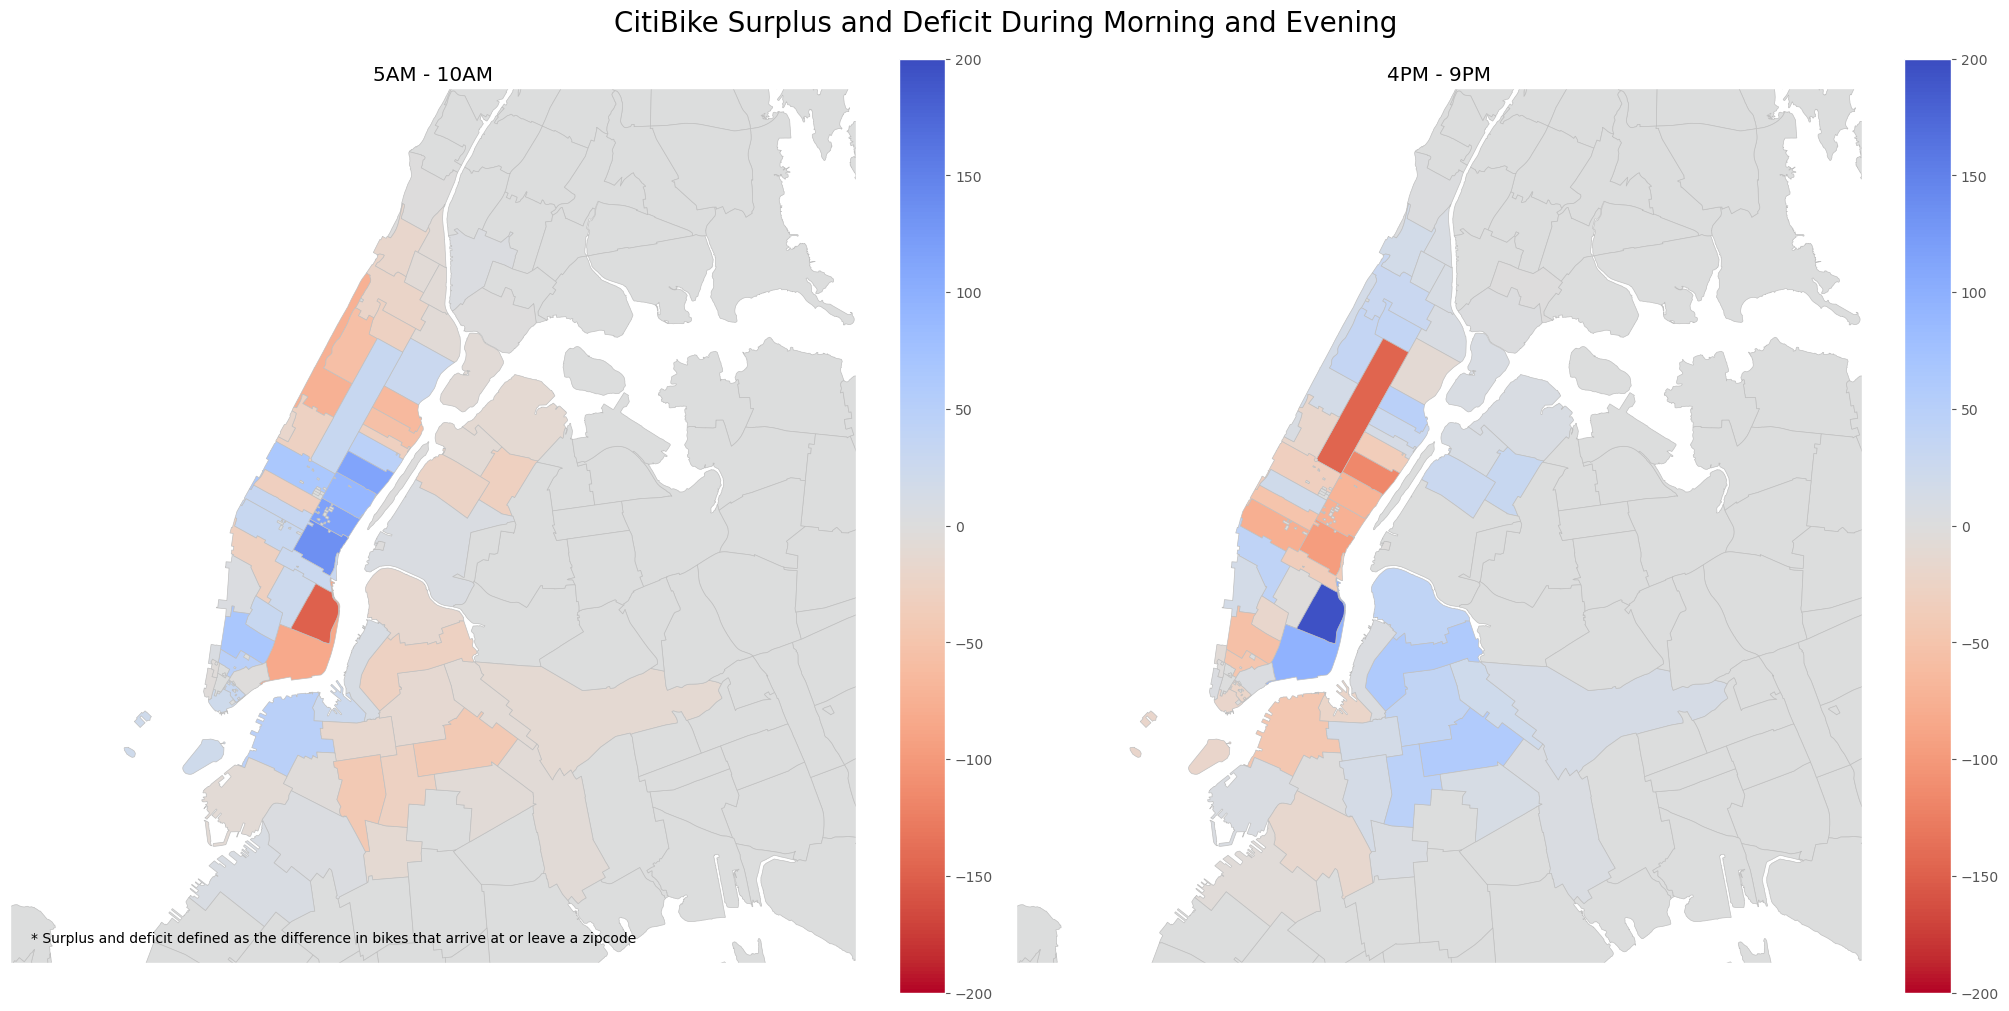

In [41]:
from matplotlib.colors import Normalize
norm = Normalize(vmin=-200, vmax=200)

fig, (ax1, ax2) = plt.subplots(1,2, 
                        figsize=(20, 10),
                        sharex=False,
                        sharey=False,
                        constrained_layout=True)
fig.suptitle('CitiBike Surplus and Deficit During Morning and Evening', fontsize=20)

zip_shp.plot(ax=ax1, column= 'surplus_AM_daily', norm=norm, cmap='coolwarm_r', edgecolor = 'silver', legend=True)

ax1.title.set_text('5AM - 10AM')
ax1.set_xlim(960000, 1042546)
ax1.set_ylim(170056, 255352)
ax1.set_facecolor("white")
ax1.grid(False)
ax1.text(962000, 172056, '* Surplus and deficit defined as the difference in bikes that arrive at or leave a zipcode')
ax1.set_xticks([])
ax1.set_yticks([])

zip_shp.plot(ax=ax2, column='surplus_PM_daily', norm=norm, cmap='coolwarm_r', edgecolor = 'silver', legend=True)

ax2.title.set_text('4PM - 9PM')
ax2.set_xlim(960000, 1042546)
ax2.set_ylim(170056, 255352)
ax2.set_facecolor("white")
ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])